In [1]:
#!/usr/bin/env python

import sys
import time
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

In [2]:
start_time = time.time()
# Script to compute similarity matrices for subregion electrostatics of each PDB. Will need to plot them too. Hmmm -> matrix heatmap.

## Load the data ##

pdbs = []
potentials = {}
data_folder = Path('data')
a = open(data_folder / 'all_spike_strs_regions_pot.csv', 'r')
for line in a:
    mm = line.split(',')
    if len(mm) == 3 and mm[0] != 'PDB ID':
        if mm[1] == 'region_1':
            pdbs.append(mm[0])
            temp_potential = [float(mm[2])]

        elif mm[1] != 'region_1':
            temp_potential.append(float(mm[2]))

        if mm[1] == 'region_21':
            potentials[mm[0]] = np.array(temp_potential)


a.close()

In [3]:
import pandas as pd
df = pd.DataFrame(potentials).T
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
6nb3,-37.007494,38.017644,0.000000,-64.447512,13.548643,-24.700141,-61.442738,39.701019,-9.367816,7.047386,...,0.000000,0.000000,-14.829590,-4.907621,-24.906685,20.196743,91.989530,-92.915405,-93.861211,-29.920780
6nb4,-39.309666,4.351932,-8.529892,-58.231302,4.455779,-24.904879,-70.019377,-15.160095,-88.910999,13.506284,...,0.000000,0.000000,-15.353076,2.676513,6.772544,41.345764,80.547941,-34.812359,-23.880191,-7.523575
6nb7,29.718320,17.444863,17.196672,50.635741,23.528359,16.992476,0.000000,-10.101497,3.839521,-4.793793,...,43.327603,-9.240390,-7.107809,0.339340,-3.329914,23.550809,0.000000,3.704321,9.623276,12.266870
6xcn,-11.623877,-11.438894,26.102622,28.683797,-15.384182,-1.396089,-24.297922,0.000000,2.181448,20.503412,...,1.221186,103.059929,11.172447,-43.979687,29.796868,-125.641598,-2.617514,4.560883,-23.991658,14.585877
6xe1,-2.818537,-59.844341,67.660837,98.990223,-37.931578,43.758384,5.777396,0.000000,14.990841,64.889319,...,-28.920803,34.941593,33.933554,41.089594,-81.166401,-93.837709,0.502137,-24.445485,59.725633,33.060191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7nd9,-1.439270,18.180753,45.639846,63.558292,-38.279262,35.410320,27.748688,0.000000,31.648613,-4.784029,...,-5.558738,57.336610,39.456045,-4.649641,12.673177,17.701092,7.585118,55.644950,21.406670,17.830524
7ndb,8.309010,-13.676192,5.470143,56.340189,-17.502078,-4.297498,41.588344,0.000000,29.713759,8.546395,...,-2.746451,-1.227531,-3.267499,-50.508540,19.557913,-81.474540,13.407211,12.373330,23.544920,10.555678
7ndc,67.673109,22.182180,1.127871,47.733260,-16.856332,4.768456,-15.643784,0.000000,40.157224,52.942158,...,9.951634,-63.130610,25.638484,29.779071,12.699822,1.805031,1.068793,-37.986890,43.624990,53.290844
7ndd,38.132149,10.315195,1.608883,91.226035,-34.970719,24.451178,4.902896,0.000000,47.742092,27.270429,...,-7.017262,-22.836347,26.832999,60.132157,30.846530,-23.816268,12.003750,-10.547584,27.930232,17.292850


In [4]:
def lower_triangle(df):
    """Compute the correlation matrix, returning only unique values."""
    lower_triangle = pd.DataFrame(
        np.tril(np.ones(df.shape), -1)).astype(bool)
    lower_triangle.index, lower_triangle.columns = df.index, df.columns
    return df.where(lower_triangle)

In [5]:
dict_dist= {}
metrics = ['cosine', 'euclidean', 'l2', 'manhattan', 'l1', 'hamming', 'chebyshev'] # 'jaccard' excluded as it's for binary data
for _metric in metrics:
    dict_dist[_metric] = pd.DataFrame(pairwise_distances(X=df, metric=_metric), index=df.index, columns=df.index)
    dict_dist[_metric] = lower_triangle(dict_dist[_metric]).stack()
df_metrics = pd.DataFrame(dict_dist)
df_metrics

cosine   euclidean          l2    manhattan           l1  \
6nb4 6nb3  0.288190  145.602781  145.602781   433.165570   433.165570   
6nb7 6nb3  1.295634  249.215516  249.215516   882.012713   882.012713   
     6nb4  1.287162  218.937090  218.937090   777.793951   777.793951   
6xcn 6nb3  1.048786  283.285662  283.285662  1051.969903  1051.969903   
     6nb4  1.132652  270.118347  270.118347   906.173982   906.173982   
...             ...         ...         ...          ...          ...   
7ntc 7nd8  0.531588  197.639670  197.639670   609.155619   609.155619   
     7nd9  0.318854  158.510661  158.510661   480.532655   480.532655   
     7ndb  0.738062  225.223504  225.223504   676.355432   676.355432   
     7ndc  0.822989  245.366533  245.366533   792.388503   792.388503   
     7ndd  0.567711  204.351454  204.351454   721.360713   721.360713   

            hamming   chebyshev  
6nb4 6nb3  0.904762   79.543183  
6nb7 6nb3  1.000000  115.083253  
     6nb4  1.000000  108.867043  
6xcn 6nb3  1.000000  145.838341  
     6nb4  1.000000  166.987362  
...             ...         ...  
7ntc 7nd8  0.952381   99.833570  
     7nd9  0.952381  100.327947  
     7ndb  0.952381  119.389193  
     7ndc  0.952381  150.770188  
     7ndd  0.952381  110.475924  

[4753 rows x 7 columns]

## Normalization

$ z = \frac{x - min(X)}{max(X)-min(X)}$

where
- $x$: a single correlation value of a metric
- $X$: the set of correlations for a single metric
- $z$: a singe *normalized* correlation value of a metric


In [6]:
stats_metrics = df_metrics.describe()
stats_metrics

,cosine,euclidean,l2,manhattan,l1,hamming,chebyshev
count,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000,4753.000000
mean,0.652209,227.366947,227.366947,790.757367,790.757367,0.960446,121.723782
std,0.311887,68.998228,68.998228,245.058471,245.058471,0.018311,43.365576
min,0.061543,47.964541,47.964541,134.773140,134.773140,0.809524,26.415275
25%,0.426062,179.426617,179.426617,619.666864,619.666864,0.952381,91.395450
50%,0.580068,213.896251,213.896251,741.311852,741.311852,0.952381,112.831046
75%,0.824549,261.265226,261.265226,916.887897,916.887897,0.952381,141.552472
max,1.782301,523.050773,523.050773,1888.536963,1888.536963,1.000000,336.504365


In [7]:
X_min = stats_metrics.loc['min']
X_max = stats_metrics.loc['max']

In [8]:
df_metrics_normalized = (df_metrics - X_min) / (X_max - X_min)
df_metrics_normalized

cosine  euclidean        l2  manhattan        l1  hamming  \
6nb4 6nb3  0.131713   0.205517  0.205517   0.170144  0.170144     0.50   
6nb7 6nb3  0.717179   0.423609  0.423609   0.426078  0.426078     1.00   
     6nb4  0.712255   0.359877  0.359877   0.366652  0.366652     1.00   
6xcn 6nb3  0.573725   0.495323  0.495323   0.522988  0.522988     1.00   
     6nb4  0.622463   0.467607  0.467607   0.439854  0.439854     1.00   
...             ...        ...       ...        ...       ...      ...   
7ntc 7nd8  0.273161   0.315048  0.315048   0.270494  0.270494     0.75   
     7nd9  0.149533   0.232686  0.232686   0.197153  0.197153     0.75   
     7ndb  0.393152   0.373109  0.373109   0.308811  0.308811     0.75   
     7ndc  0.442506   0.415508  0.415508   0.374974  0.374974     0.75   
     7ndd  0.294154   0.329176  0.329176   0.334474  0.334474     0.75   

           chebyshev  
6nb4 6nb3   0.171331  
6nb7 6nb3   0.285944  
     6nb4   0.265897  
6xcn 6nb3   0.385125  
     6nb4   0.453328  
...              ...  
7ntc 7nd8   0.236765  
     7nd9   0.238359  
     7ndb   0.299830  
     7ndc   0.401030  
     7ndd   0.271085  

[4753 rows x 7 columns]

## Plotting the mean metrics heatmap

In [9]:
mean_metrics = df_metrics_normalized.mean(axis=1).unstack()
mean_metrics

,6nb3,6nb4,6nb7,6xcn,6xe1,6zdh,7DDD,7a5r,7a5s,7akj,...,7n8h,7nd4,7nd5,7nd6,7nd7,7nd8,7nd9,7ndb,7ndc,7ndd
6nb4,0.222052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6nb7,0.528928,0.490173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6xcn,0.570782,0.555816,0.507191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6xe1,0.713024,0.684743,0.566041,0.416526,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6zdh,0.610799,0.631911,0.565863,0.565553,0.689677,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7nd9,0.627162,0.577183,0.388795,0.387863,0.385835,0.615716,0.275605,0.429589,0.384117,0.571683,...,0.243026,0.301387,0.307656,0.264037,0.354194,0.236932,NaN,NaN,NaN,NaN
7ndb,0.588585,0.564359,0.414080,0.283918,0.379692,0.661686,0.332840,0.497567,0.474482,0.660595,...,0.254574,0.349181,0.276387,0.294574,0.258899,0.340271,0.306191,NaN,NaN,NaN
7ndc,0.581746,0.550646,0.359544,0.499324,0.418226,0.566389,0.380969,0.443288,0.463681,0.665655,...,0.395083,0.377293,0.288713,0.388978,0.208823,0.323272,0.395657,0.354349,NaN,NaN
7ndd,0.620525,0.589698,0.361322,0.426604,0.365695,0.599545,0.327004,0.423618,0.362305,0.648582,...,0.306893,0.357078,0.275406,0.282400,0.213532,0.281270,0.296731,0.309149,0.20568,NaN


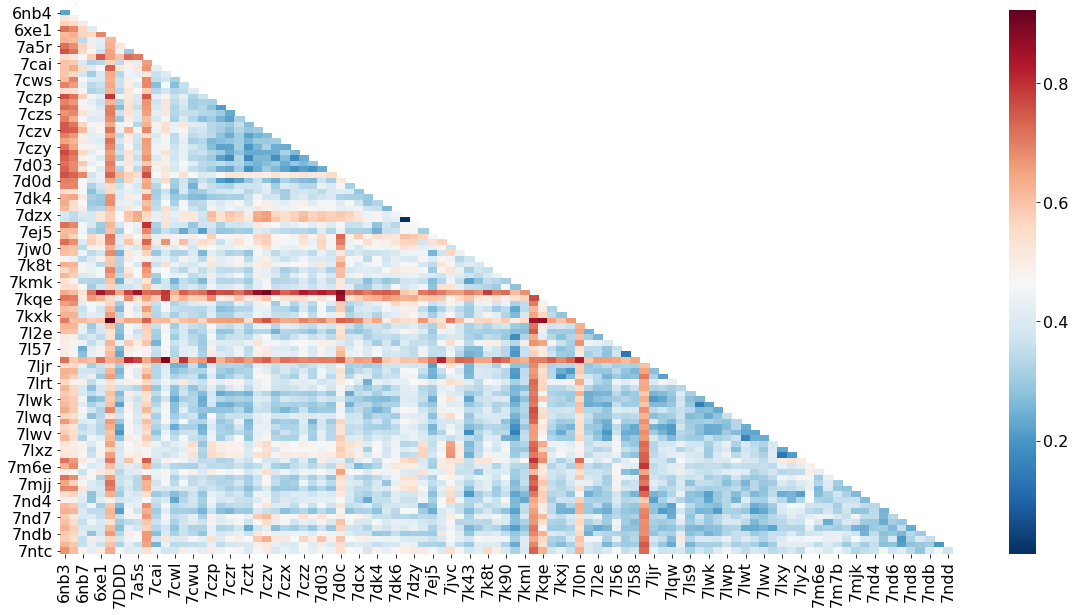

In [10]:
# Set up the matplotlib figure
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)

fig, ax = plt.subplots(figsize=(20,10)) 

ax = sns.heatmap(mean_metrics, annot=False, cmap="RdBu_r", ax=ax) #annot=labels, fmt='',annot_kws={"size": 14}, cmap="RdBu_r") #fmt="0.2f",  cmap="RdBu_r")